### Intro

The goal of that project is to detect is on the picture road exists or not. 
I created that project for the Zindi competition - [Road Segment Identification](https://zindi.africa/competitions/road-segment-identification).
With my solution, I took 19th place.

I was also taking inspiration from Olufemi Victor Tolulope's [solution](https://github.com/osinkolu/Road-Segment-Identification-Zindi/blob/main/Best_RoadSegment_classifier_ever.ipynb).

In [5]:
import pandas as pd
from PIL import Image
from imgaug import augmenters as iaa
import os
import numpy as np
import shutil
from fastai.vision.all import *

In [6]:
train = pd.read_csv(r'/Users/tomaszbicki/Desktop/road detection/Train.csv')
train

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1
...,...,...
6995,ID_zup5UL43,1
6996,ID_zvZNJeQB,0
6997,ID_zwGbT2eY,1
6998,ID_zxWcykW8,1


In [7]:
train['Target'].value_counts()

Target
1    3771
0    3229
Name: count, dtype: int64

### Data Augmentation

I wanted to enlarge the size of my training set by using data augmentation techniques. Because photos from the test set have similar brightness and colors I focused only on flipping techniques. I didn't use cropping because there was a risk that photo was labeled as '1' (with road), and cropped would lose that road from an image.

In [8]:
def imgOpen(img_index):
    img = Image.open('/Users/tomaszbicki/Desktop/road detection/Images_Train/'+train['Image_ID'].iloc[img_index]+'.tif')
    img = np.array(img)
    return img

In [9]:
seq1 = iaa.Sequential([
    iaa.Fliplr(1)
])

seq2 = iaa.Sequential([
    iaa.Flipud(1)
])

In [ ]:
## I had problem with augemntation only train data so i sorted photos to different folders

In [10]:
orginal_path = '/Users/tomaszbicki/Desktop/road detection/Images/'
train_path = '/Users/tomaszbicki/Desktop/road detection/Images_Train/'
test_path = '/Users/tomaszbicki/Desktop/road detection/Images_Test/'
for x in os.listdir(orginal_path):
    name = x[:-4] 
    if name in list(train['Image_ID']):
        shutil.move(orginal_path+x, train_path+x)
    else:
        shutil.move(orginal_path+x, test_path+x)

In [11]:
augmented_image_ids = []
augmented_targets = []
for x in train.index:
    img = imgOpen(x)
    
    img_aug1 = seq1(image = img) #Changing from 'images' to 'image' helped to run that function
    img_aug1_name = train['Image_ID'].iloc[x]+'aug_1' 
    path1 = f'/Users/tomaszbicki/Desktop/road detection/Images_Train/{img_aug1_name}.tif'
    img_aug_pil1 = Image.fromarray(img_aug1)
    img_aug_pil1.save(path1)
    
    img_aug2 = seq2(image = img)
    img_aug2_name = train['Image_ID'].iloc[x]+'aug_2'
    path2 = f'/Users/tomaszbicki/Desktop/road detection/Images_Train/{img_aug2_name}.tif'
    img_aug_pil2 = Image.fromarray(img_aug2)
    img_aug_pil2.save(path2)
    
    
    augmented_image_ids.extend([img_aug1_name, img_aug2_name])
    augmented_targets.extend([train['Target'].iloc[x], train['Target'].iloc[x]])
    
augmented_data = pd.DataFrame({'Image_ID': augmented_image_ids, 'Target': augmented_targets})
    
train = pd.concat([train, augmented_data], ignore_index=True)


In [12]:
file_list = os.listdir(train_path)
len(file_list)

21000

In [13]:
train

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1
...,...,...
20995,ID_zwGbT2eYaug_2,1
20996,ID_zxWcykW8aug_1,1
20997,ID_zxWcykW8aug_2,1
20998,ID_zzzvJs0Faug_1,1


### Training Model

I used FastAi to simplify the whole process. During creating Datablock I used stratify parameter to keep proportion in train and test datasets. 

Learning the model on my personal computer was a mistake because it took too much time, I should use i.e. Google Colab.

Finally, I achieved an error rate of around 0.1, train loss and valid loss had similar values which was a good thing also. I could train a model for a few more epochs but I wanted to finish the project.

In [14]:
road = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    splitter = TrainTestSplitter(0.1, stratify=train["Target"]),
    get_x = ColReader(0), 
    get_y = ColReader(1))

In [15]:
train['Image_ID'] = ['/Users/tomaszbicki/Desktop/road detection/Images_Train/'+x+'.tif' for x in train['Image_ID']]

In [16]:
dls = road.dataloaders(train, bs=8)

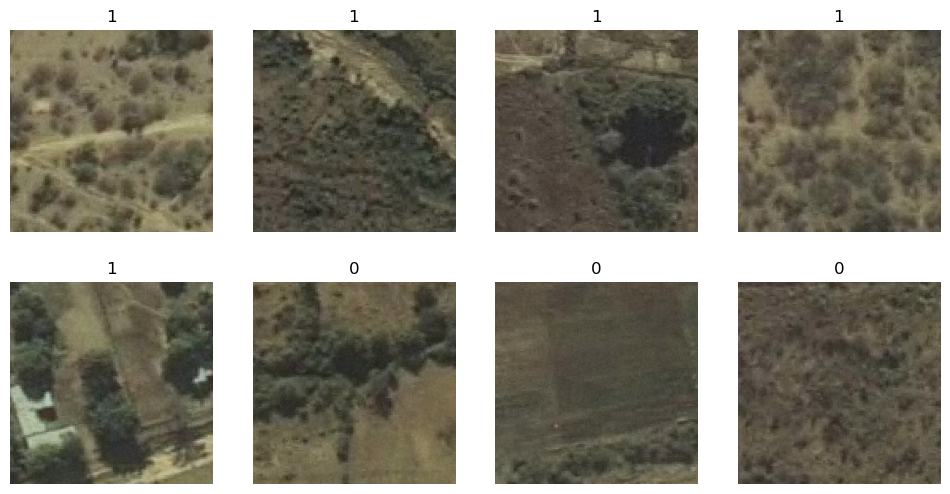

In [17]:
dls.train.show_batch()

In [18]:
import torchvision.models as models
learn = cnn_learner(dls, models.resnet34, cut=-1,metrics=error_rate)

/Users/tomaszbicki/anaconda3/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/Users/tomaszbicki/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/tomaszbicki/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/t

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [19]:
learn.fine_tune(5, cbs=MixUp(0.2))

epoch,train_loss,valid_loss,error_rate,time
0,0.584949,0.443548,0.207619,19:26:12


epoch,train_loss,valid_loss,error_rate,time
0,0.468028,0.338830,0.132857,5:32:19
1,0.502698,0.349326,0.133333,3:53:43
2,0.459421,0.297029,0.118571,4:53:26
3,0.341098,0.263706,0.108571,12:36:38
4,0.290231,0.257152,0.109048,4:43:06


### Final Results

In the end, I used TTA to improve the results. I got a 0.943389274 score.

In [21]:
test = pd.read_csv(r'/Users/tomaszbicki/Desktop/road detection/Test.csv')
test

,Image_ID
0,ID_01c6i2wd
1,ID_03sPqBLY
2,ID_06ZKUQFl
3,ID_06gzqIwK
4,ID_08kWat36
...,...
2995,ID_zxBFKP2n
2996,ID_zxN7nQbW
2997,ID_zyWc0ENM
2998,ID_zywRGuyq


In [23]:
ss = pd.read_csv(r'/Users/tomaszbicki/Desktop/road detection/SampleSubmission.csv')
ss

,Image_ID,Target
0,ID_01c6i2wd,NaN
1,ID_03sPqBLY,NaN
2,ID_06ZKUQFl,NaN
3,ID_06gzqIwK,NaN
4,ID_08kWat36,NaN
...,...,...
2995,ID_zxBFKP2n,NaN
2996,ID_zxN7nQbW,NaN
2997,ID_zyWc0ENM,NaN
2998,ID_zywRGuyq,NaN


In [24]:
tdl = learn.dls.test_dl(test['Image_ID'].map(lambda x: '/Users/tomaszbicki/Desktop/road detection/Images_Test/'+x+'.tif').values)
test_preds_tta, test_labels_tta = learn.tta(dl=tdl)
preds = [p[1] for p in test_preds_tta.numpy()]

In [31]:
test['Target'] = preds
test

,Image_ID,Target
0,ID_01c6i2wd,0.157862
1,ID_03sPqBLY,0.052583
2,ID_06ZKUQFl,0.998361
3,ID_06gzqIwK,0.038403
4,ID_08kWat36,0.437226
...,...,...
2995,ID_zxBFKP2n,0.105203
2996,ID_zxN7nQbW,0.227590
2997,ID_zyWc0ENM,0.806949
2998,ID_zywRGuyq,0.210020


In [33]:
name = 'solution_road_zindi'
test.to_csv(f'/Users/tomaszbicki/Desktop/road detection/{name}', index = False)

In [35]:
learn.export(r'/Users/tomaszbicki/Desktop/road detection/model.pkl')